In [1]:
import os
from glob import glob
import numpy as np
import pickle
from scipy import stats
from osl_dynamics.models import load
from osl_dynamics.data import Data
from osl_dynamics.utils import plotting
from osl_dynamics.inference import modes
from osl_dynamics.analysis import spectral, power
from bonus import covariates

n_modes = 4
run = 2

BASE_DIR = "//sum-lpnc-nas.u-ga.fr/SecureVault/LPNC-SecureVault/MEGAGING/Processed/osl_processing"
# BASE_DIR = "/run/user/1001/gvfs/smb-share:server=sum-lpnc-nas.u-ga.fr,share=securevault/LPNC-SecureVault/MEGAGING/Processed/osl_processing"
MODEL_DIR = f"{BASE_DIR}/train_dynemo_1_90/{n_modes:02d}_modes/run{run:02d}/model"
OUTPUT_DIR = f"{BASE_DIR}/train_dynemo_1_90/{n_modes:02d}_modes/run{run:02d}/inf_params"
os.makedirs(f"{OUTPUT_DIR}", exist_ok=True)

# Demographics & Covariates
age_group_dict = {
    'bm_014': 1, # young
    'ca_001': 1,
    'ca_019': 2, # old
    'cc_007': 2,
    'cm_013': 2,
    'dm_022': 1,
    'el_018': 1,
    'gb_020': 2,
    'gh_017': 1,
    'gp_011': 2,
    'gv_005': 2,
    'lf_012': 2,
    'lr_008': 1,
    'pe_009': 1,
    'pl_016': 1,
    'pr_015': 2,
    'ra_003': 1,
    're_002': 1,
    'sg_010': 1
}
age = np.array(list(age_group_dict.values()))

# Reorder subjects
subject_list = list(age_group_dict.keys()) # Order by which epochs are sorted in dim 0
sorted_subject_list = sorted(subject_list, key=lambda x: int(''.join(filter(str.isdigit, x))))

# Separate subjects into two lists by age group
young_subjects = [name for name in sorted_subject_list if age_group_dict[name] == 1]
old_subjects = [name for name in sorted_subject_list if age_group_dict[name] == 2]

DATA LOADING

In [ ]:
# unprepared_files = sorted(glob(f"{BASE_DIR}/derivatives_1_90/*/sflip_parc-raw.fif"))
# data = Data(unprepared_files, picks="misc", reject_by_annotation='omit', n_jobs=16)
# trimmed_data = data.trim_time_series(n_embeddings=15, sequence_length=100)

In [2]:
alpha = pickle.load(open(f"{OUTPUT_DIR}/alp.pkl", "rb"))
covs = np.load(f"{OUTPUT_DIR}/covs.npy")

alpha = modes.reweight_alphas(alpha, covs)

COMPUTATIONS

In [ ]:
# sfreq=250

# # Calculate regression spectra for each mode and subject (will take a few minutes)
# f, psd, coh, w = spectral.regression_spectra(
#     data=trimmed_data,
#     alpha=alpha,
#     sampling_frequency=sfreq,
#     frequency_range=[1, 90],
#     window_length=sfreq*4,
#     step_size=40,
#     n_sub_windows=2,
#     return_coef_int=True,
#     return_weights=True,
#     n_jobs=2,
# )

# print(f.shape)
# print(psd.shape)
# print(coh.shape)
# print(w.shape)

# np.save(f"{OUTPUT_DIR}/f.npy", f)
# np.save(f"{OUTPUT_DIR}/psd.npy", psd)
# np.save(f"{OUTPUT_DIR}/coh.npy", coh)
# np.save(f"{OUTPUT_DIR}/w.npy", w)

PLOTTING

In [3]:
f = np.load(f"{OUTPUT_DIR}/f.npy")
psd = np.load(f"{OUTPUT_DIR}/psd.npy")
coh = np.load(f"{OUTPUT_DIR}/coh.npy")
w = np.load(f"{OUTPUT_DIR}/w.npy")

(4, 178)


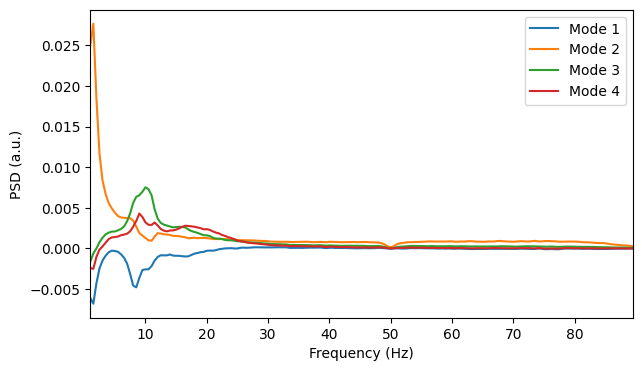

In [7]:
psd_coefs = psd[:, 0] # Discarding the interpect term (static spectra) # (subjects,modes,channels,freqs)
# Average over subjects and channels
psd_coefs_group = np.average(psd_coefs,axis=0, weights=w) # (modes,channels,freqs)
psd_coefs_group_parcelavg = np.mean(psd_coefs_group, axis=1) # (modes,freqs)
print(psd_coefs_group_parcelavg.shape)

# Plot
n_modes = psd_coefs_group_parcelavg.shape[0]
fig, ax = plotting.plot_line(
    [f] * n_modes,
    psd_coefs_group_parcelavg,
    labels=[f"Mode {i}" for i in range(1, n_modes + 1)],
    x_label="Frequency (Hz)",
    y_label="PSD (a.u.)",
    x_range=[f[0], f[-1]],
)

In [9]:
pow = power.variance_from_spectra(f, psd_coefs) # (subjects, modes, channels)
gpow = np.average(pow, axis=0, weights=w) # (modes, channels)
np.save(f"{OUTPUT_DIR}/mean_power.npy", gpow) # For computing RSN composition
idx_parcels = np.argsort(np.abs(gpow)) 
np.save(f"{OUTPUT_DIR}/idx_parcels_power.npy", idx_parcels) # For selecting most-powered channels

# power.multi_save(
#     group_power_map=gpow*1000,
#     subject_power_map=pow*1000,
#     mask_file="MNI152_T1_8mm_brain.nii.gz",
#     parcellation_file="Glasser52_binary_space-MNI152NLin6_res-8x8x8.nii.gz",
#     subtract_mean=False,
#     plot_kwargs={
#                 "cmap": "RdBu_r",
#                 "bg_on_data": True,
#                 "darkness": 1,
#                 "alpha": 1,
#                 "vmin": -int(np.max(abs(gpow)*1000)),
#                 "vmax": int(np.max(abs(gpow)*1000)),
#                 "views": ['lateral'],
#             },
#     filename=f"{OUTPUT_DIR}/sub_powermaps/multipow_.png"
# )

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2024-10-09 08:54:18 INFO nibabel.global [batteryrunners.py:268:log_raise]: pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
C:\Users\Clement\AppData\Local\Temp\ipykernel_12980\1528562266.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


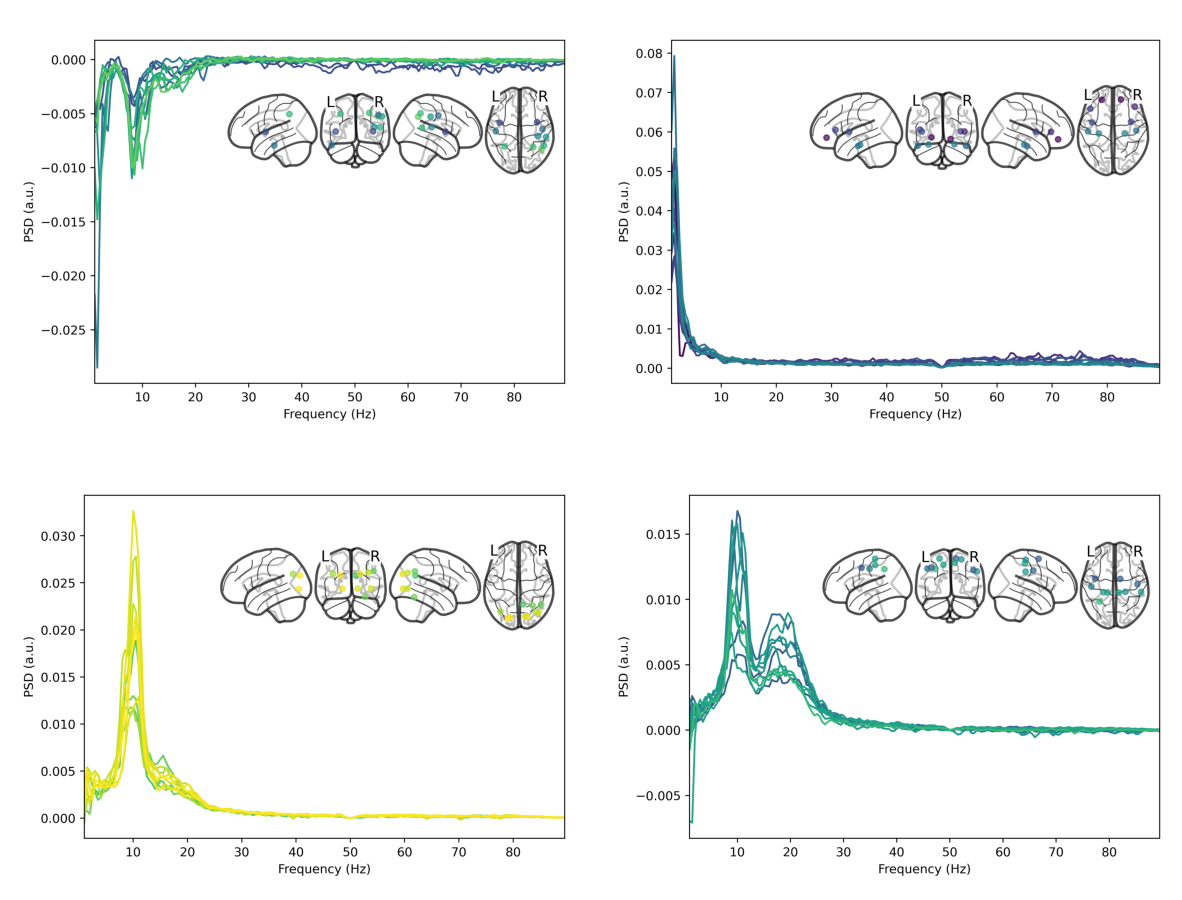

In [12]:
from osl_dynamics.utils.plotting import plot_psd_topo, plot_markers
from osl_dynamics.utils.parcellation import Parcellation
import matplotlib.pyplot as plt
from matplotlib import colors, image

# Re-order to use colour to indicate anterior->posterior location
parcellation = Parcellation("Glasser52_binary_space-MNI152NLin6_res-8x8x8.nii.gz")
roi_centers = parcellation.roi_centers()
order = np.argsort(roi_centers[:, 1]) # Anterior-to-Posterior reordering of the parcels

psd_coefs_reordered = psd_coefs[:,:,order,:] # PSD at the subject level
gpsd_coefs_reordered = np.average(psd_coefs_reordered, axis=0, weights=w) # PSD at the group level
idx_parcels_reordered = np.argsort(np.abs(gpow[:,order])) # Sorted indices of the most-powered channels
num_parcels=10


fig, axes = plt.subplots(2,2,figsize=(15,15))
plt.subplots_adjust(wspace=0.05,hspace=-0.35)

for mode, subax in enumerate(axes.flat):
    fig, ax = plot_psd_topo(f,
                  gpsd_coefs_reordered[mode],
                  only_show=idx_parcels_reordered[mode,-(num_parcels):], # plot the n channels with the largest power
                  )
    
    plot_markers(
        np.arange(num_parcels),
        roi_centers[order][idx_parcels_reordered[mode,-(num_parcels):]],
        node_cmap= colors.LinearSegmentedColormap.from_list(
            "cmap",
            plt.cm.viridis_r(np.linspace(0,1,52))[idx_parcels_reordered[mode,-(num_parcels):]],
        ),
        node_size=20,
        colorbar=False,
        display_mode='lyrz',
        axes=ax.inset_axes([0.28,0.35,0.7,0.7])
    )

    plt.tight_layout()
    img_path = f"{OUTPUT_DIR}/PSD_{mode+1}.png"
    plt.savefig(img_path, dpi = 400)
    plt.close()

    img_to_embed = image.imread(img_path, format='png')
    subax.imshow(img_to_embed)
    subax.axis('off')

plt.savefig(f"{OUTPUT_DIR}/PSD_all+topoplot.png", dpi=300)

In [ ]:
from osl_dynamics.analysis import connectivity

c = connectivity.mean_coherence_from_spectra(f, coh)
print(c.shape)

# Average over subjects
mean_c = np.average(c, axis=0, weights=w)

# Threshold the top 3% relative to the mean
thres_mean_c = connectivity.threshold(mean_c, percentile=97, subtract_mean=True)
connectivity.save(
    thres_mean_c,
    parcellation_file="Glasser52_binary_space-MNI152NLin6_res-8x8x8.nii.gz",
    plot_kwargs={"edge_vmin": -0.3, "edge_vmax": 0.3, "edge_cmap": "RdBu_r"},
)